In [11]:
# """!pip install fancyimpute==0.7.0
# !pip install -U imbalanced-learn
# !pip install joblib==1.0.1
# !pip install matplotlib==3.3.4
# !pip install numpy==1.19.5
# !pip install pandas==1.3.5
# !pip install scikit_learn==0.24.2
# !pip install scipy==1.6.2
# !pip install seaborn==0.11.1
# !pip install six==1.15.0
# !pip install xgboost==1.5.1
# !pip install fancyimpute

# """

In [12]:
#pip freeze > requirements.txt

In [13]:
#pip install -r requirements.txt


In [1]:
from fancyimpute import KNN, SoftImpute

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import LabelBinarizer,StandardScaler,OrdinalEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from scipy.stats import boxcox
from sklearn.linear_model import LogisticRegression,RidgeClassifier, PassiveAggressiveClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import joblib

%matplotlib inline


In [3]:
import operator

In [4]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

In [5]:
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

In [6]:
from sklearn.utils import _safe_indexing
sys.modules['sklearn.utils.safe_indexing'] = sklearn.utils._safe_indexing

In [7]:
from imblearn.over_sampling import SMOTE

In [8]:

def classify(est, x, y,X_test,y_test):
    #Passing the model and train test dataset to fit the model
    est.fit(x, y)
    #Predicting the probabilities of the Tet data
    y2 = est.predict_proba(X_test)
    y1 = est.predict(X_test)

    print("Accuracy: ", metrics.accuracy_score(y_test, y1))
    print("Area under the ROC curve: ", metrics.roc_auc_score(y_test, y2[:, 1]))
    #Calculate different metrics
    print("F-metric: ", metrics.f1_score(y_test, y1))
    print(" ")
    print("Classification report:")
    print(metrics.classification_report(y_test, y1))
    print(" ")
    print("Evaluation by cross-validation:")
    print(cross_val_score(est, x, y))
    
    return est, y1, y2[:, 1]


#Function to find which features are more important than others through model
def feat_importance(estimator):
    feature_importance = {}
    for index, name in enumerate(df_LC.columns):
        feature_importance[name] = estimator.feature_importances_[index]

    feature_importance = {k: v for k, v in feature_importance.items()}
    sorted_x = sorted(feature_importance.items(), key=operator.itemgetter(1), reverse = True)
    
    return sorted_x

#Model to  predict the ROC curve for various models and finding the best one
def run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced'):
    
    clfs = {'GradientBoosting': GradientBoostingClassifier(max_depth= 6, n_estimators=100, max_features = 0.3),
            'LogisticRegression' : LogisticRegression(),
            #'GaussianNB': GaussianNB(),
            'RandomForestClassifier': RandomForestClassifier(n_estimators=10),
            'XGBClassifier': XGBClassifier()
            }
    cols = ['model','matthews_corrcoef', 'roc_auc_score', 'precision_score', 'recall_score','f1_score']

    models_report = pd.DataFrame(columns = cols)
    conf_matrix = dict()

    for clf, clf_name in zip(clfs.values(), clfs.keys()):

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_score = clf.predict_proba(X_test)[:,1]

        print('computing {} - {} '.format(clf_name, model_type))

        tmp = pd.Series({'model_type': model_type,
                         'model': clf_name,
                         'roc_auc_score' : metrics.roc_auc_score(y_test, y_score),
                         'matthews_corrcoef': metrics.matthews_corrcoef(y_test, y_pred),
                         'precision_score': metrics.precision_score(y_test, y_pred),
                         'recall_score': metrics.recall_score(y_test, y_pred),
                         'f1_score': metrics.f1_score(y_test, y_pred)})

        models_report = models_report.append(tmp, ignore_index = True)
        conf_matrix[clf_name] = pd.crosstab(y_test, y_pred, rownames=['True'], colnames= ['Predicted'], margins=False)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, drop_intermediate = False, pos_label = 1)

        plt.figure(1, figsize=(6,6))
        plt.xlabel('false positive rate')
        plt.ylabel('true positive rate')
        plt.title('ROC curve - {}'.format(model_type))
        plt.plot(fpr, tpr, label = clf_name )
        plt.legend(loc=2, prop={'size':11})
    plt.plot([0,1],[0,1], color = 'black')
    
    return models_report, conf_matrix

In [9]:
#Importing the datasets
data =pd.read_csv("https://s3.amazonaws.com/hackerday.datascience/358/LoansTrainingSetV2.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (10,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
data.head()
len(data)

111107

In [11]:
##Drop the duplicates with respect to LOAN ID
data.drop_duplicates(subset="Loan ID",keep='first',inplace=True)

In [12]:
len(data)

88910

- EDA: Loan Status (Target var)

In [17]:
data["Loan Status"]

0        Loan Refused
1        Loan Refused
2        Loan Refused
3        Loan Refused
4        Loan Refused
             ...     
88905      Loan Given
88906      Loan Given
88907      Loan Given
88908    Loan Refused
88909      Loan Given
Name: Loan Status, Length: 88910, dtype: object

Check for imbalance in distribution of target variable

Loan Given      63737
Loan Refused    25173
Name: Loan Status, dtype: int64


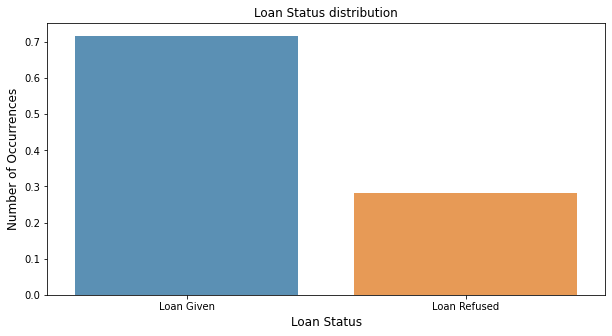

In [24]:
##########PLotting the loan status 
print(data["Loan Status"].value_counts()) # Check for data-imbalance


status=data["Loan Status"].value_counts(normalize=True) # Check for data-imbalance


plt.figure(figsize=(10,5))
sns.barplot(x=status.index, y=status.values, alpha=0.8)
plt.title('Loan Status distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Loan Status', fontsize=12)
plt.show();

## EDA-Quartiles and Quantiles

- Quartiles
  - Found in box plots. 
  - Each quartile has 1/4 of the dataset.
  - IQR (Interquartile Range)=(Q3-Q1)
  - Minimum= Q1-1.5xIQR
  - Maximum = Q3+1.5xIQR
  - Values above max and below min are OUTLIERS.

- Quantile
  - The nth percent of a dataset.
  - 20% (or 0.2) quantile is calculated by 0.2x(n+1), where n is the number of observations. If n=5, then 0.2(6)=1.2, so the 1st observation is the 20% quantile.
  - 80% (or 0.8) quantile is calculated by 0.8x(n+1), where n is the number of observations. If n=5, then 0.8(6)=4.8, so the 5th observation is the 80% quantile.

- EDA: Current Loan Amount

count    8.891000e+04
mean     1.433878e+07
std      3.502996e+07
min      4.910000e+02
25%      8.283000e+03
50%      1.435500e+04
75%      2.448500e+04
max      1.000000e+08
Name: Current Loan Amount, dtype: float64


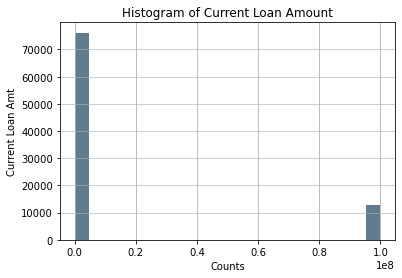

In [27]:
###Current Loan Amount ############
print(data["Current Loan Amount"].describe())

# Visualize with a histogram-Group data into buckets and get the number of observations belonging to each bucket.
# We see that there are some very high outliers. (Also identifiable by comparing the magnitude of the 75% percentile and max value) 
data["Current Loan Amount"].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Histogram of Current Loan Amount')
plt.xlabel('Counts')
plt.ylabel('Current Loan Amt')
plt.grid(axis='y', alpha=0.75)


In [28]:
#Finding IQR's for outlier removal

Q1 = data["Current Loan Amount"].quantile(0.25)
Q3 = data["Current Loan Amount"].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

16202.0


In [29]:
# Get the outlier datapoints
# Outliers are datapoints below the minimum = Q1-1.5*IQR and above the maximum = Q3+1.5*IQR
data["Current Loan Amount"][((data["Current Loan Amount"] < (Q1 - 1.5 * IQR)) |(data["Current Loan Amount"] > (Q3 + 1.5 * IQR)))]


5044     99999999
5045     99999999
5046     99999999
5047     99999999
5048     99999999
           ...   
17777    99999999
17778    99999999
17779    99999999
17780    99999999
17781    99999999
Name: Current Loan Amount, Length: 12738, dtype: int64

Based on the above, we see that values with  99999999 are probably some fill-in value for missing values.

In [30]:
# Let's replace 99999999 with a single value. First, convert to NaN.
temp=np.array(data["Current Loan Amount"].values.tolist()) # convert column to list, then to np array.
data["Current Loan Amount_temp"] = np.where(temp > 9999998, 'NaN', temp).tolist() 
# "np.where" performs filtering on an np array, by replacing values > 9999998 with NaN, otherwise keeping the original value.


count    76172.000000
mean     13933.915756
std       8235.921922
min        491.000000
25%       7810.000000
50%      12038.000000
75%      19351.000000
max      35875.000000
Name: Current Loan Amount_temp, dtype: float64

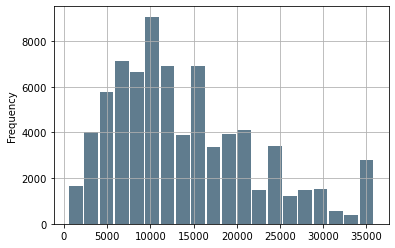

In [32]:
# Remove NaN values from "Current Loan Amount_temp" and plot a histogram again.
temp=data["Current Loan Amount_temp"][data["Current Loan Amount_temp"]!='NaN'].astype(str).astype(int)
temp.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
                   
temp.describe()


In [33]:
#Replacing the data with 50% percentile or mean
temp=np.array(data["Current Loan Amount"].values.tolist())
data["Current Loan Amount"] = np.where(temp > 9999998,12038,temp).tolist()

data=data.drop(['Current Loan Amount_temp'],axis=1)

- EDA: Term (categorical variable)

In [34]:
data["Term"].unique()

array(['Short Term', 'Long Term'], dtype=object)

In [40]:
# Check for any missing values
#data["Term"].isnull().values.any()
data["Term"].isnull().sum()

0

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


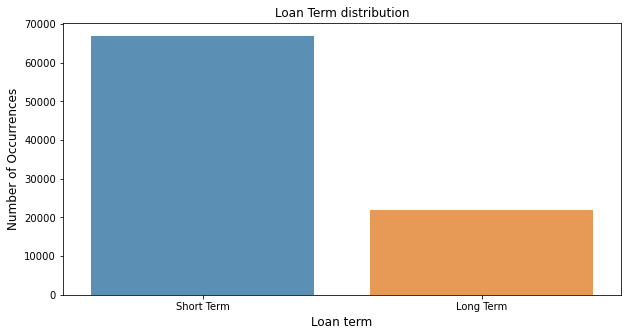

In [35]:

############Term ##############

status=data["Term"].value_counts() 

plt.figure(figsize=(10,5))
sns.barplot(status.index, status.values, alpha=0.8)
plt.title('Loan Term distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Loan term', fontsize=12)
plt.show()


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


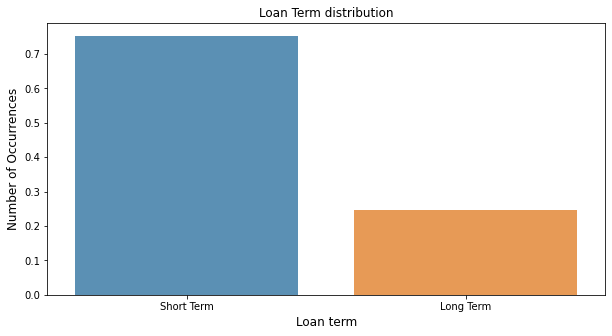

In [36]:
status=data["Term"].value_counts(normalize=True) 

plt.figure(figsize=(10,5))
sns.barplot(status.index, status.values, alpha=0.8)
plt.title('Loan Term distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Loan term', fontsize=12)
plt.show()


- EDA: Credit Score
- should be between 0-800.

count    67572.000000
mean      1199.199580
std       1680.813805
min        585.000000
25%        714.000000
50%        733.000000
75%        744.000000
max       7510.000000
Name: Credit Score, dtype: float64


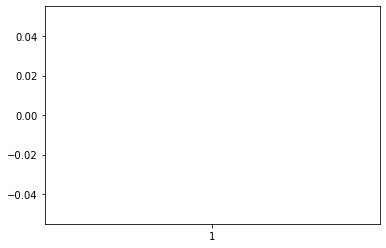

In [43]:
#####Credit Score#############

print(data["Credit Score"].describe())
##Max is 7510. It should be between 0-800. We cannot plot the boxplot, due to some errors present in the data. (Null values and extreme outliers.)
plt.boxplot(data["Credit Score"])
plt.show()


In [44]:
data["Credit Score"].isnull().sum()


21338

In [46]:
#Now lets do treatment of the data at hand. Let us firstly divide the values greater than 800 by 10

data["Credit Score"]=np.where(data["Credit Score"]>800, data["Credit Score"]/10, data["Credit Score"])


685.0


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Credit Score_1', ylabel='Density'>

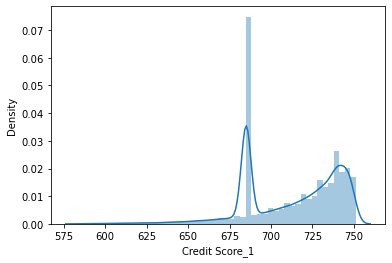

In [47]:
#Now lets replace the missing values with median 
median_score=statistics.median(data["Credit Score"])
print(median_score)

data["Credit Score_1"]=data["Credit Score"]
data["Credit Score_1"].fillna(median_score, inplace = True) 

sns.distplot(data["Credit Score_1"])


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


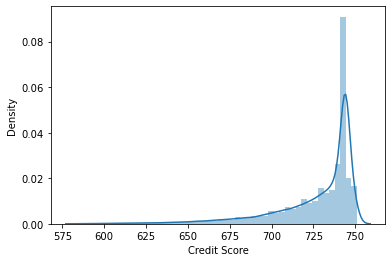

In [52]:
#As we can see this data is skewed so when we replace it with median it is giving us problems. 
#Replacing with 75th percentile and taking log we get a better distribution


data["Credit Score"].fillna(744, inplace = True) 

sns.distplot(data["Credit Score"]);

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Credit Score', ylabel='Density'>

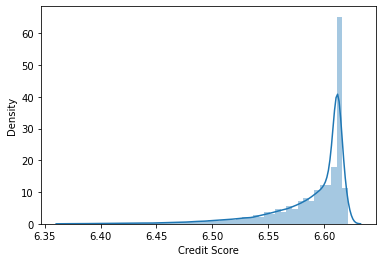

In [53]:
sns.distplot(np.log(data["Credit Score"]))

Still, even after doing a log-transform, the distribution of credit score is skewed, meaning that the imputation of our data is not that good. Later on, we will have to use an imputation algorithm to fill in the NaN values. The imputing algorithm will use all the other variables associated with credit score, instead of just a single value, to fill in the missing values. 

- EDA: Home Ownership

In [55]:
data['Home Ownership'].unique()
#As we can see it has Home Mortgage and haveMortgage as 2 different classes. There should be only 3 classes: rent, home mortgage and own home.
#Lets fix that.


array(['Rent', 'Home Mortgage', 'Own Home', 'HaveMortgage'], dtype=object)

In [56]:
data['Home Ownership']=data['Home Ownership'].str.replace('HaveMortgage', 'Home Mortgage', regex=True)

data['Home Ownership'].unique()


array(['Rent', 'Home Mortgage', 'Own Home'], dtype=object)

- EDA: Annual Income (Continuous var)

In [ ]:
##################Annual Income######################
data['Annual Income'].describe()


count    6.757200e+04
mean     7.234575e+04
std      5.836101e+04
min      4.033000e+03
25%      4.458600e+04
50%      6.149400e+04
75%      8.675025e+04
max      8.713547e+06
Name: Annual Income, dtype: float64

In [58]:
##Lets look at the quantiles of this columns, to see where outliers are present.
# 0.2 or 20% quantile is the value at the position: 0,2 x (n+1), where n is the number of observations/data points. 

data['Annual Income'].quantile([.2,0.75,0.90,.95,0.99,.999])


0.200     40764.00
0.750     86750.25
0.900    119916.00
0.950    147645.00
0.990    239286.96
0.999    491575.77
Name: Annual Income, dtype: float64

In [ ]:
#As we can see they lie in the 99th percentile of the data.Lets replace them
# Capping any values greater than 99% to 99th value
data.loc[data['Annual Income'] > 239287, 'Annual Income'] = 239287 #Conditional that returns a boolean Series with column labels specified


data['Annual Income'].isna().sum()
#So we have about 21000 null values 

##We will impute the mising data with other columns towards the end


21338

- EDA: Purpose (Categorical var)

In [59]:


###############Loan Purpose ###############

data['Purpose'].value_counts()
#So other and Other mean the same thing. Lets make it the same


Debt Consolidation      70447
Home Improvements        5206
other                    4917
Other                    2850
Business Loan            1328
Buy a Car                1196
Medical Bills             955
Buy House                 559
Take a Trip               454
major_purchase            344
small_business            248
moving                    124
wedding                    99
Educational Expenses       92
vacation                   82
renewable_energy            9
Name: Purpose, dtype: int64

In [60]:
# 'Other' and 'other' are the same category. Need to combine them into 1 catgeory.
data['Purpose']=data['Purpose'].str.replace('Other', 'other', regex=True)

- EDA: monthly debt

In [70]:
data['Monthly Debt'].dtype

dtype('O')

In [61]:
#######Monthly debt ###############


data['Monthly Debt'].describe()
##So this is not numeric column. Lets explore


count     88910
unique    76609
top           0
freq         55
Name: Monthly Debt, dtype: object

In [71]:
data['Monthly Debt'] 
# But this should be a numeric column. So lets convert it to float


0         777.39
1         892.09
2        1244.02
3         990.94
4         503.71
          ...   
88905     567.62
88906    2508.63
88907      818.2
88908     360.17
88909     749.13
Name: Monthly Debt, Length: 88910, dtype: object

In [73]:
#pd.to_numeric(data['Monthly Debt'] )
#As we can see there is a $ symbol present. Lets replace it 


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Monthly Debt', ylabel='Density'>

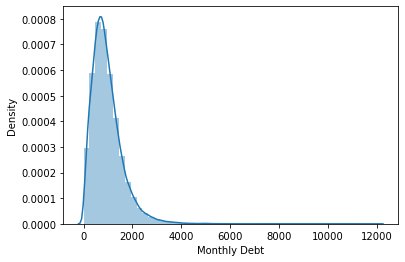

In [74]:
data['Monthly Debt']=data['Monthly Debt'].str.replace('$', '', regex=True)

data['Monthly Debt']=pd.to_numeric(data['Monthly Debt'] )

sns.distplot(data["Monthly Debt"])


In [75]:
#We can see that there are outliers in this data because of the plot
#Lets explore

data['Monthly Debt'].describe()
#The max value is too high here


count    65536.000000
mean       962.406632
std        632.799593
min          0.000000
25%        532.250000
50%        843.770000
75%       1251.342500
max      12055.680000
Name: Monthly Debt, dtype: float64

In [77]:
data['Monthly Debt'].quantile([.2,0.75,0.90,.95,0.99,.999])


0.200     464.21000
0.750    1251.34250
0.900    1740.35000
0.950    2112.21000
0.990    3084.08600
0.999    4927.21625
Name: Monthly Debt, dtype: float64

In [78]:
#Problem is with 99th percentile. lets dig deeper

data['Monthly Debt'].quantile([0.9995,.9999])
#So problem again is wit 99th percentile


0.9995    5513.352425
0.9999    7719.187600
Name: Monthly Debt, dtype: float64

In [79]:
data['Monthly Debt'].quantile([0.9997,.99999])
#0.99970     5978.574911
#0.99999    13262.762330


0.99970     5979.063765
0.99999    11253.511940
Name: Monthly Debt, dtype: float64

In [82]:
data['Monthly Debt'].quantile([0.999,1])


0.999    4926.0
1.000    4926.0
Name: Monthly Debt, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Monthly Debt', ylabel='Density'>

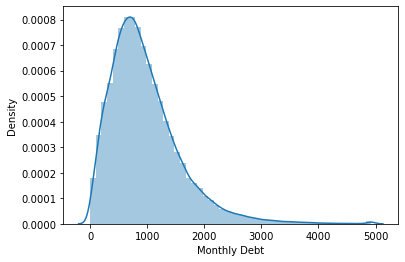

In [81]:
#Need to replace this
data.loc[data['Monthly Debt'] > 4926, 'Monthly Debt'] = 4926

sns.distplot(data["Monthly Debt"])
#Now we get the right distribution


- EDA: Years of credit history

count    88910.000000
mean        18.315313
std          7.049175
min          3.600000
25%         13.500000
50%         17.000000
75%         21.800000
max         70.500000
Name: Years of Credit History, dtype: float64
16.0    1234
15.0    1159
17.0    1091
16.5    1045
14.0    1031
        ... 
51.6       1
59.5       1
62.5       1
65.0       1
51.3       1
Name: Years of Credit History, Length: 508, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Years of Credit History', ylabel='Density'>

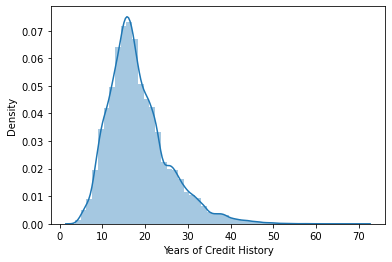

In [90]:
####################Years of credit history #################
print(data['Years of Credit History'].describe())
print(data['Years of Credit History'].value_counts())


sns.distplot(data["Years of Credit History"])
#Over all looks pretty clean! no need of doing anything


- EDA: Months since last delinquent

In [91]:
#############Months since last delinquent####################

data['Months since last delinquent'].describe()


count    40404.000000
mean        35.080289
std         22.008583
min          0.000000
25%         16.000000
50%         32.000000
75%         51.000000
max        176.000000
Name: Months since last delinquent, dtype: float64

In [93]:
#Lets check if there are any NA's
print(len(data))
data['Months since last delinquent'].isna().sum()
#We have nearly 48506 NA;s. We will try to handle them at last 


88910


48506

- EDA: Number of Open Accounts

In [94]:
##############Number of open accounts ##############

data['Number of Open Accounts'].describe()
#The max number seems odd. Lets investigate


count    88910.000000
mean        11.110348
std          4.978461
min          0.000000
25%          8.000000
50%         10.000000
75%         14.000000
max         76.000000
Name: Number of Open Accounts, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Number of Open Accounts', ylabel='Density'>

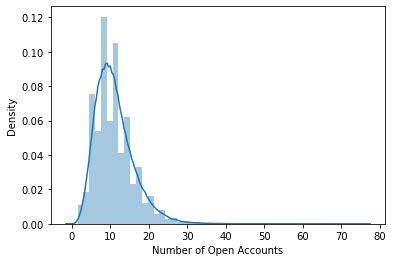

In [95]:
sns.distplot(data['Number of Open Accounts'])
#Yes there are outliers in this columns. Let dig deeper


In [96]:
data['Number of Open Accounts'].quantile([0.75,0.999,1])
#Ok so replacing anything greater than 99th percentile with 99th percentile values


0.750    14.0
0.999    36.0
1.000    76.0
Name: Number of Open Accounts, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Number of Open Accounts', ylabel='Density'>

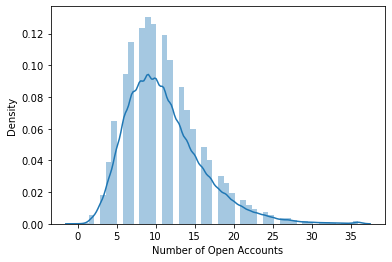

In [97]:
data.loc[data['Number of Open Accounts'] > 36, 'Number of Open Accounts'] = 36


sns.distplot(data['Number of Open Accounts'])
#Looks good now


- EDA: Number of credit problems

count    88910.000000
mean         0.160477
std          0.473746
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         15.000000
Name: Number of Credit Problems, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Number of Credit Problems', ylabel='Density'>

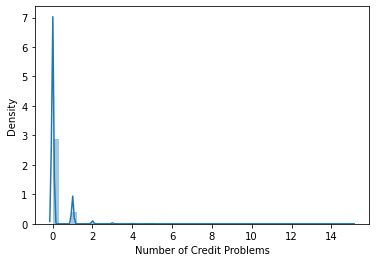

In [99]:

#######################Number of Credit problems##############

print(data['Number of Credit Problems'].describe()) 
#Max looks a bit higher. Lets see

sns.distplot(data['Number of Credit Problems'])


In [100]:
#Okay lets look at value _counts


data['Number of Credit Problems'].value_counts()

#Okay looks good


0     77057
1     10271
2      1092
3       311
4       101
5        46
6        14
7         6
9         4
10        3
8         2
12        1
15        1
11        1
Name: Number of Credit Problems, dtype: int64

- EDA: Current Credit Balance

count    8.891000e+04
mean     1.543593e+04
std      1.965873e+04
min      0.000000e+00
25%      5.949000e+03
50%      1.103900e+04
75%      1.930100e+04
max      1.730472e+06
Name: Current Credit Balance, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Current Credit Balance', ylabel='Density'>

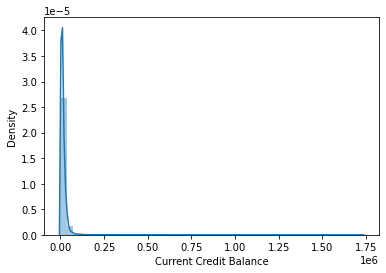

In [101]:
##################Current Credit Balance###########

print(data['Current Credit Balance'].describe())

sns.distplot(data['Current Credit Balance'])
#It seems there are outliers in this data. Lets investigate


In [102]:
data['Current Credit Balance'].quantile([0.75,0.95,0.999,1])


0.750      19301.000
0.950      39933.300
0.999     227670.033
1.000    1730472.000
Name: Current Credit Balance, dtype: float64

In [103]:
#lets dig deeper

data['Current Credit Balance'].quantile([0.95,0.96,0.97,0.98,0.99,1])


0.95      39933.30
0.96      43501.20
0.97      48507.73
0.98      57938.12
0.99      81007.19
1.00    1730472.00
Name: Current Credit Balance, dtype: float64

In [104]:
#So lets replace it with 95th percentile

data['Current Credit Balance'].quantile([0.55,0.76,0.87,0.98,0.99,1])


0.55      12295.00
0.76      19805.84
0.87      27525.66
0.98      57938.12
0.99      81007.19
1.00    1730472.00
Name: Current Credit Balance, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Current Credit Balance', ylabel='Density'>

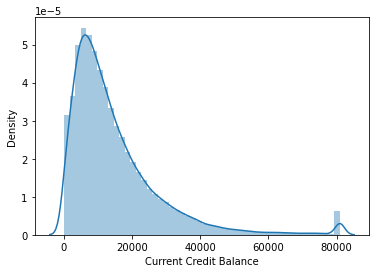

In [108]:
data.loc[data['Current Credit Balance'] > 81007, 'Current Credit Balance'] = 81007
sns.distplot(data['Current Credit Balance'])


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Current Credit Balance', ylabel='Density'>

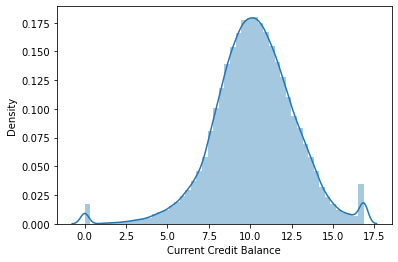

In [111]:
#The plot doesnt look good, because it is skewed to the right. We need to transform it by doing a log-transform, or taking a square root.
sns.distplot(data['Current Credit Balance']**(1/2))
# After taking square root, the distribution looks close to normal.

In [110]:
data['Current Credit Balance']=data['Current Credit Balance']**(1/2)


- EDA: Maximum Open Credit

In [112]:
#######################Max open credit################

data['Maximum Open Credit'].describe()


count     88910
unique    58216
top           0
freq        450
Name: Maximum Open Credit, dtype: object

In [117]:
data['Maximum Open Credit'].dtype

dtype('O')

In [113]:
data['Maximum Open Credit'].value_counts()


0         450
0         160
15847       9
17464       9
6827        8
         ... 
28296       1
10199       1
132602      1
10395       1
21124       1
Name: Maximum Open Credit, Length: 58216, dtype: int64

In [115]:
#sns.distplot(data['Maximum Open Credit'])
#So there are some str characters present in the data. Lets find them
#could not convert string to float: '#VALUE!'


In [119]:
#pd.to_numeric(data['Maximum Open Credit'])
#Unable to parse string "#VALUE!" at position 4930

In [120]:
#Lets replace #value with Nan
data['Maximum Open Credit']=data['Maximum Open Credit'].replace('#VALUE!', np.nan, regex=True)


In [121]:
data['Maximum Open Credit']=pd.to_numeric(data['Maximum Open Credit'])


In [122]:
data['Maximum Open Credit'].isnull().sum()
#Now we have only 2 Nan;s in the data. Lets replace them with mean  


2

In [123]:
data['Maximum Open Credit'].mean()

35965.310174562466

In [124]:
data['Maximum Open Credit']=data['Maximum Open Credit'].fillna(35965)


In [125]:
data['Maximum Open Credit'].quantile([0.55,0.76,0.87,0.98,0.99,1])



0.55       24037.95
0.76       37259.84
0.87       50736.66
0.98      114682.56
0.99      171423.91
1.00    69988086.00
Name: Maximum Open Credit, dtype: float64

In [126]:
#Lets replace the outliers
data.loc[data['Maximum Open Credit'] > 171423, 'Maximum Open Credit'] = 171423


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


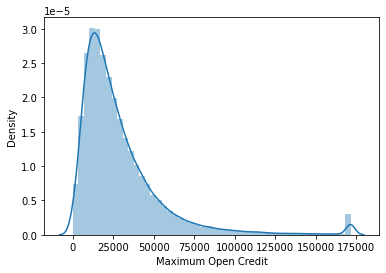

In [128]:
sns.distplot(data['Maximum Open Credit']);

- EDA: Bankruptcies

In [129]:
###############Bankruptcies##########
data['Bankruptcies'].describe()


count    88718.000000
mean         0.112672
std          0.343300
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: Bankruptcies, dtype: float64

In [130]:
data['Bankruptcies'].value_counts()


0.0    79323
1.0     8936
2.0      353
3.0       80
4.0       19
5.0        5
7.0        1
6.0        1
Name: Bankruptcies, dtype: int64

In [131]:
data['Bankruptcies'].unique()

#So we have Nan's. Lets fill them with median


array([ 0.,  1., nan,  2.,  4.,  3.,  5.,  7.,  6.])

In [132]:
data['Bankruptcies']=data['Bankruptcies'].fillna(3)


In [133]:
data['Bankruptcies'].value_counts()

0.0    79323
1.0     8936
2.0      353
3.0      272
4.0       19
5.0        5
7.0        1
6.0        1
Name: Bankruptcies, dtype: int64

- EDA: Tax Liens

In [134]:
####Tax Liens######

data['Tax Liens'].describe()


count    88902.000000
mean         0.028222
std          0.257533
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         15.000000
Name: Tax Liens, dtype: float64

In [135]:
data['Tax Liens'].value_counts()



0.0     87274
1.0      1132
2.0       305
3.0        99
4.0        52
5.0        17
6.0         9
7.0         5
9.0         4
8.0         2
15.0        1
10.0        1
11.0        1
Name: Tax Liens, dtype: int64

## Prepare features for model building-Ordinality & dummy variables for categorical vars
- Ordinality: encode categorical variables into numerical categories, where the order matters. e.g. 0 for short term and 1 for long term.
- Dummy variables: If we have n categories for a feature, we create n-1 dummy variables. A dummy variable is a flag that indicates if a data point belongs to a particular category. 

# Impute missing values, using relationship of a feature with missing values with other features. 
### Imputation strategies: (All ensure that the missing values being imputed will lead to the feature being normally distributed).
- Soft impute, 
- KNN etc. 


In [137]:
data['Years in current job'].unique()

array(['< 1 year', '10+ years', '9 years', '3 years', '2 years',
       '7 years', '6 years', '1 year', '5 years', '4 years', '8 years',
       nan], dtype=object)

In [151]:
# Test functionality of pd.factorize()
# pd.factorize: Encode the object as an enumerated type or categorical variable.
#This method is useful for obtaining a numeric representation of an array when all that matters is identifying distinct values.
pd.set_option('display.max_columns', None)
pd.factorize(data['Years in current job'])


(array([ 0,  1,  2, ..., -1, -1,  6], dtype=int64),
 Index(['< 1 year', '10+ years', '9 years', '3 years', '2 years', '7 years',
        '6 years', '1 year', '5 years', '4 years', '8 years'],
       dtype='object'))

In [152]:
cat_cols = ['Term','Years in current job','Home Ownership','Purpose']

for c in cat_cols:
    data[c] = pd.factorize(data[c])[0]

In [ ]:
#Imputing missing data with soft impute
updated_data=pd.DataFrame(data=SoftImpute().fit_transform(data[data.columns[3:19]],), columns=data[data.columns[3:19]].columns, index=data.index)
#Getting the dataset ready pd.get dummies function for dropping the dummy variables
df_LC = pd.get_dummies(updated_data, drop_first=True)

[SoftImpute] Max Singular Value of X_init = 23092221.868378
[SoftImpute] Iter 1: observed MAE=261.480152 rank=3
[SoftImpute] Iter 2: observed MAE=258.548469 rank=3
[SoftImpute] Iter 3: observed MAE=258.207662 rank=3
[SoftImpute] Iter 4: observed MAE=258.184852 rank=3
[SoftImpute] Iter 5: observed MAE=258.204643 rank=3
[SoftImpute] Iter 6: observed MAE=258.230069 rank=3
[SoftImpute] Iter 7: observed MAE=258.255573 rank=3
[SoftImpute] Iter 8: observed MAE=258.280106 rank=3
[SoftImpute] Iter 9: observed MAE=258.303449 rank=3
[SoftImpute] Iter 10: observed MAE=258.325504 rank=3
[SoftImpute] Iter 11: observed MAE=258.346214 rank=3
[SoftImpute] Iter 12: observed MAE=258.365509 rank=3
[SoftImpute] Iter 13: observed MAE=258.383517 rank=3
[SoftImpute] Iter 14: observed MAE=258.400220 rank=3
[SoftImpute] Iter 15: observed MAE=258.415645 rank=3
[SoftImpute] Iter 16: observed MAE=258.429899 rank=3
[SoftImpute] Iter 17: observed MAE=258.443135 rank=3
[SoftImpute] Iter 18: observed MAE=258.455321 ra

In [ ]:

#Binarizing the Target variable
lb_style = LabelBinarizer()
lb_results = lb_style.fit_transform(data['Loan Status'])
y=lb_results
y=y.ravel()


#Scaling the independent variables
X_scaled = preprocessing.scale(df_LC)
print(X_scaled)
print('   ')
print(X_scaled.shape)


[[-0.1869176  -0.57302977  0.06886311 ... -0.79845518 -0.32295035
  -0.10958408]
 [ 1.48349848  1.74511004  0.26644983 ...  1.83825771 -0.32295035
  -0.10958408]
 [ 0.32079375 -0.57302977 -0.08920626 ... -0.53977375  2.39304617
  -0.10958408]
 ...
 [ 1.40247376 -0.57302977  0.78017528 ...  0.91232955 -0.32295035
  -0.10958408]
 [-1.1281112  -0.57302977 -0.16824094 ... -0.4039368  -0.32295035
  -0.10958408]
 [ 0.62515919 -0.57302977 -0.32631031 ... -0.30218149 -0.32295035
   3.77361205]]
   
(88910, 16)


In [ ]:
#######Looking at other models using different classifiers
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=22)

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:58:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:  0.7276646796385858
Area under the ROC curve:  0.7437786371367399
F-metric:  0.38419803323160395
 
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.90      0.83     18981
           1       0.55      0.29      0.38      7692

    accuracy                           0.73     26673
   macro avg       0.66      0.60      0.60     26673
weighted avg       0.70      0.73      0.70     26673

 
Evaluation by cross-validation:


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:59:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:59:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:59:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:59:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:59:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.73088046 0.73762853 0.73150157 0.73150157 0.72740419]
[0.15770203 0.25137326 0.16299246 0.02831689 0.04490009 0.04055737
 0.03080421 0.03046158 0.02761248 0.02706706 0.02785725 0.02524857
 0.03073877 0.03578309 0.03659303 0.0419918 ]


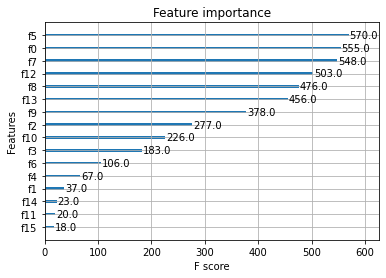

In [ ]:
#Finding accuracy and feature importance using XGB classifier
xgb0, y_pred_b, y_pred2_b = classify(XGBClassifier(), X_train, y_train,X_test,y_test)
print(xgb0.feature_importances_)
plot_importance(xgb0)
pyplot.show()
feat1 = feat_importance(xgb0)


In [ ]:
xgb0, y_pred_b, y_pred2_b = classify(XGBClassifier(n_estimators=47, learning_rate=0.015), X_train, y_train,X_test,y_test)

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:59:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:  0.7290893412814456
Area under the ROC curve:  0.7381679994031858
F-metric:  0.3351122561648877
 
Classification report:
              precision    recall  f1-score   support

           0       0.75      0.93      0.83     18981
           1       0.57      0.24      0.34      7692

    accuracy                           0.73     26673
   macro avg       0.66      0.58      0.58     26673
weighted avg       0.70      0.73      0.69     26673

 
Evaluation by cross-validation:


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:59:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:00:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:00:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:00:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:00:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.73666452 0.74116324 0.73608098 0.73664337 0.73013578]


In [ ]:
#######K nearest Neighbour classifier ################

knc, y_p, y_p2 = classify(KNeighborsClassifier(), X_train, y_train,X_test,y_test)


Accuracy:  0.6839500618603082
Area under the ROC curve:  0.6073078340129547
F-metric:  0.30992141453831046
 
Classification report:
              precision    recall  f1-score   support

           0       0.74      0.86      0.80     18981
           1       0.42      0.25      0.31      7692

    accuracy                           0.68     26673
   macro avg       0.58      0.55      0.55     26673
weighted avg       0.65      0.68      0.66     26673

 
Evaluation by cross-validation:
[0.69368573 0.69705977 0.69783884 0.69141159 0.68747489]


In [ ]:
########Logistic Regression ##############
logit, y_p, y_p2 = classify(LogisticRegression(), X_train, y_train,X_test,y_test)

Accuracy:  0.7201289693697747
Area under the ROC curve:  0.6722709585903062
F-metric:  0.21213720316622697
 
Classification report:
              precision    recall  f1-score   support

           0       0.73      0.96      0.83     18981
           1       0.56      0.13      0.21      7692

    accuracy                           0.72     26673
   macro avg       0.65      0.54      0.52     26673
weighted avg       0.68      0.72      0.65     26673

 
Evaluation by cross-validation:
[0.72606041 0.72919344 0.72812726 0.7282076  0.72684181]


In [ ]:
########Decision Tree Classifier ##########
dtc, y_p, y_p2 = classify(DecisionTreeClassifier(), X_train, y_train,X_test,y_test)

Accuracy:  0.6518576838000975
Area under the ROC curve:  0.5790952295591429
F-metric:  0.40282958199356916
 
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.75      0.75     18981
           1       0.40      0.41      0.40      7692

    accuracy                           0.65     26673
   macro avg       0.58      0.58      0.58     26673
weighted avg       0.65      0.65      0.65     26673

 
Evaluation by cross-validation:
[0.65713368 0.65745501 0.65549932 0.66128384 0.65268739]


computing GradientBoosting - Non-balanced 
computing LogisticRegression - Non-balanced 
computing RandomForestClassifier - Non-balanced 


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:02:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
computing XGBClassifier - Non-balanced 


,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,GradientBoosting,0.242773,0.753738,0.576281,0.250296,0.349008,Non-balanced
1,LogisticRegression,0.158180,0.672405,0.554031,0.127651,0.207495,Non-balanced
2,RandomForestClassifier,0.199133,0.701102,0.510873,0.244500,0.330720,Non-balanced
3,XGBClassifier,0.245700,0.743843,0.547578,0.290344,0.379477,Non-balanced


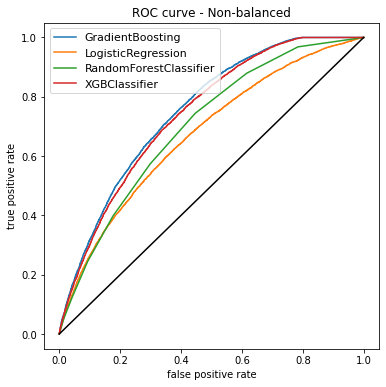

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)
models_report, conf_matrix = run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced')
models_report

computing GradientBoosting - Balanced 
computing LogisticRegression - Balanced 
computing RandomForestClassifier - Balanced 


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:03:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
computing XGBClassifier - Balanced 


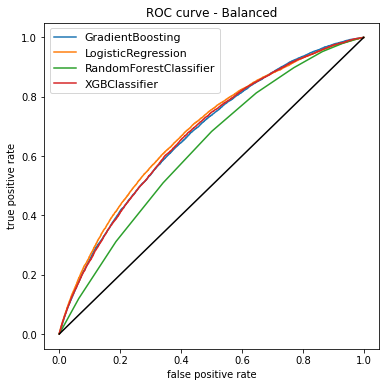

In [ ]:
###########Synthetically balancing the dataset##################
index_split = int(len(X_scaled)/2)
X_train, y_train = SMOTE().fit_resample(X_scaled[0:index_split, :], y[0:index_split])
X_test, y_test = X_scaled[index_split:], y[index_split:]
models_report_bal, conf_matrix_bal = run_models(X_train, y_train, X_test, y_test, model_type = 'Balanced')

In [ ]:
################Now we  know that GBM model performed the best so 
# save model
gbm=GradientBoostingClassifier(max_depth= 6, n_estimators=100, max_features = 0.3)
gbm.fit(X_scaled, y)
joblib.dump(gbm, 'GBM_Model_version1.pkl')
# load model
#gbm_pickle = joblib.load('GBM_Model_version1.pkl')

['GBM_Model_version1.pkl']